<a href="https://colab.research.google.com/github/khushbooG9/Pointer-Networks-Using-Fast-Weights/blob/master/Pointer_Networks_with_LSTM_v1_3e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Dev incorporation in training
- Inference print layout difference
- Better multi epoch training code
- Updated loss to per output
- Function for data prep

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [0]:
tf.enable_eager_execution()
np.random.seed(42)
tf.random.set_random_seed(42)

# Experiment Configuration

In [3]:
hidden_dimensions=300 #tune

minSeqSize=3
maxSeqSize=6

batchSize=16
numOfBatches=100
datasize=batchSize*numOfBatches*(maxSeqSize-minSeqSize+1)
datasize

6400

### Prepare dataset

In [0]:
def makeData(minSeqSize,maxSeqSize,batchSize,numOfBatches):
    X={}
    Y={}
    datasize=batchSize*numOfBatches*(maxSeqSize-minSeqSize+1)
    
    for seqLen in range(minSeqSize,maxSeqSize+1):
        X[seqLen]=[]
        Y[seqLen]=[]


        for dataidx in range(int(datasize/(maxSeqSize-minSeqSize+1))):

            # aSeq:
            #       - seqLen x 2
            #       - col 1: zero and col 2: numbers

            # X
            seqBase=np.random.uniform(size=(1,seqLen-1))
            aSeq=np.concatenate((np.zeros((1,seqLen-1),dtype=np.float32),seqBase),axis=0)
            aSeq=aSeq.T
            aSeq=np.concatenate((np.array([[1,0]],dtype=np.float32),aSeq),axis=0)
            X[seqLen]+=[aSeq]

            # Y
            aRec=[]
            for e in np.sort(seqBase[0]):
                idx=list(seqBase[0]).index(e)
                aRec+=[np.zeros(seqLen,dtype=np.float32)]
                aRec[-1][idx+1]=1
            aRec+=[np.zeros(seqLen,dtype=np.float32)]
            aRec[-1][0]=1
            Y[seqLen]+=[aRec]


        X[seqLen]=np.array(X[seqLen],dtype=np.float32)
        Y[seqLen]=np.array(Y[seqLen],dtype=np.float32)
    return X,Y

In [0]:
trainX,trainY=makeData(minSeqSize,maxSeqSize,batchSize,numOfBatches)

In [6]:
print('Train X for',minSeqSize,':',trainX[minSeqSize].shape)
print('Train Y for',minSeqSize,':',trainY[minSeqSize].shape)

Train X for 3 : (1600, 3, 2)
Train Y for 3 : (1600, 3, 3)


## Encoder & Decoder Network

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, hidden_dimensions):
        super(Encoder, self).__init__()
        self.lstm = layers.CuDNNLSTM(hidden_dimensions, return_sequences=True, return_state=True)
        
    def call(self, x):
        output, state_h, state_c  = self.lstm(x)        
        return output, [state_h, state_c]

In [0]:
class Decoder(tf.keras.Model):
     def __init__(self, hidden_dimensions):
        super(Decoder, self).__init__()
        self.lstm = layers.CuDNNLSTM(hidden_dimensions, return_sequences=True, return_state=True)
     
     def call(self, x, hidden_states):
        dec_output, state_h, state_c  = self.lstm(x, initial_state=hidden_states)
        # dec_output shape -> (batch_size, 1, hidden_dimension)

        return dec_output, [state_h, state_c]

In [0]:
class Attention(tf.keras.Model):
     def __init__(self, hidden_dimensions):
        super(Attention, self).__init__()
        # Note: Dense layer -> dot(input, kernel) -> so now Ui = vT . tanh(W1 . e + W2 . di)  becomes Ui = tanh(e . W1 + di . W2) . v
        self.W1 = tf.keras.layers.Dense(hidden_dimensions, use_bias=False) # weights -> (256, 256)
        self.W2 = tf.keras.layers.Dense(hidden_dimensions, use_bias=False) # weights -> (256, 256)
        self.V = tf.keras.layers.Dense(1, use_bias=False) # weights -> (256, 1)
        
     
     def call(self, encoder_outputs, dec_output):
        # encoder_outputs shape -> (batch_size, input_sequence_length, hidden_dimension) -> (32, 9, 256)
        # dec_output shape -> (batch_size, 1, hidden_dimension) -> (32, 1, 256)

        # w1_e -> (*, 9, 256) * (*, 256, 256) -> (*, 9, 256)
        w1_e = self.W1(encoder_outputs)
        
        # w2_e -> (*, 1, 256) * (*, 256, 256) -> (*, 1, 256)
        w2_d = self.W2(dec_output)
        
        # tanh_output -> (*, 9, 256) + (*, 1, 256) -> (*, 9, 256)
        tanh_output = tf.nn.tanh(w1_e + w2_d)
        
        # tanh_output -> (*, 9, 256) + (*, 256, 1) -> (*, 9, 1)
        v_dot_tanh = self.V(tanh_output)
        
        # attention_weights -> (batch_size, input_sequence_length, 1) -> (32, 9, 1)
        attention_weights = tf.nn.softmax(v_dot_tanh, axis=1)
        
        return tf.reshape(attention_weights, (attention_weights.shape[0], attention_weights.shape[1])) # (batch_size, input_sequence_length) -> (32, 9)

### Initialize encoder and decoder network

In [0]:
encoder = Encoder(hidden_dimensions)
decoder = Decoder(hidden_dimensions)
attention = Attention(hidden_dimensions)

### Batch Infer Function

In [0]:
def infer(encoder,decoder,attention,X,Y,verbose=0):
    loss=0
    
    if verbose==2:
        print('X:')
        print(X)
        print('Y:')
        print(Y)

    #Initialize values
    attention_vector_array = []
    final_output_sequence = []

    encoder_input, target_data=X,Y
    # encoder_input -> (batch_size, input_sequence_length, input_dimension)
    # target_data -> (batch_size, input_sequence_length, input_sequence_length)

    # run the decoder
    encoder_outputs, encoder_states = encoder(encoder_input)

    # prepare initial decoder input
    dec_input = tf.convert_to_tensor(np.array([[[0,0]]]*X.shape[0],dtype=np.float32))
    # dec_input -> (batch_size, 1, input_dimension)

    # loading the final encoder states to decoder network as initial hidden states
    decoder_states = encoder_states
    # decoder states -> (batch_size, hidden_state_dimension)

    # iterrate over the times of input sequence size
    if verbose==2:
        print('\n\nPREDICTIONS')
        print('-----------')
    
    result=[]
    for i in range(0, encoder_input.shape[1]):
        result+=[[0]*encoder_input.shape[0]]
        # run decoder's single step for one input
        decoder_output, decoder_states = decoder(dec_input, decoder_states)
        # decoder outputs -> (batch_size, input_lenght=1, hidden_state_dimension)
        # decoder states -> (batch_size, hidden_state_dimension)

        # target prediction -> (batch_size, input_sequence_length)
        # target prediction points to one of the input sequence element -> element with highest value
        target_prediction = attention(encoder_outputs, decoder_output)

        # used for training the network by using the target data
        ei_slice_stack=[]
        tarCounter=0
        for tar_data_slice in target_prediction:
            ei_slice_stack+=[encoder_input[tarCounter,np.argmax(tar_data_slice)]]
            tarCounter+=1
        ei_slice_stack=tf.convert_to_tensor(np.array(ei_slice_stack,dtype=np.float32))

        if verbose==2:
            outputCounter=0
            print('\nFor position:',i)
            for x in X:
                print("\tInput %d, Predicted:%d->%s"%(outputCounter,np.argmax(target_prediction[outputCounter]), str(x[np.argmax(target_prediction[outputCounter])])),
                     '\tExpected:%d->%s:'%(np.argmax(target_data[outputCounter,i]),encoder_input[outputCounter,np.argmax(target_data[outputCounter,i])]))
                outputCounter+=1
        if verbose==1:
            outputCounter=0
            for x in X:
                result[-1][outputCounter]=encoder_input[outputCounter,np.argmax(target_prediction[outputCounter])]
                outputCounter+=1


        loss += tf.reduce_mean(tf.keras.backend.categorical_crossentropy(target_data[:,i], target_prediction))
        
        # load the input state to decoder network for next prediction
        dec_input = tf.expand_dims(ei_slice_stack, 1)

    if verbose==1:
        outputCounter=-1
        for x in X:
            outputCounter+=1
            print('\n===== PREDICTED:',outputCounter,'=====\n')
            for i in range(0, encoder_input.shape[1]):
                print('\t-',result[i][outputCounter])
            print('\n--- ACTUAL:',outputCounter,'---\n')
            for i in range(0, encoder_input.shape[1]):
                print('\t-',encoder_input[outputCounter][np.argmax(target_data[outputCounter][i])])

            
    return loss.numpy()/(X.shape[1])

#### Output of network before training

In [12]:
# Use data point
seqLen=minSeqSize
infer(encoder,decoder,attention,trainX[seqLen][0:2],trainY[seqLen][0:2],1)

Instructions for updating:
Colocations handled automatically by placer.

===== PREDICTED: 0 =====

	- [1. 0.]
	- [1. 0.]
	- [1. 0.]

--- ACTUAL: 0 ---

	- [0.         0.37454012]
	- [0.        0.9507143]
	- [1. 0.]

===== PREDICTED: 1 =====

	- [1. 0.]
	- [1. 0.]
	- [1. 0.]

--- ACTUAL: 1 ---

	- [0.        0.5986585]
	- [0.        0.7319939]
	- [1. 0.]


1.098620096842448

### Train Model

#### Prep training data

In [0]:
batchedDataset={}
for seqLen in range(minSeqSize,maxSeqSize+1):
    batchedDataset[seqLen]=[]
    for aBatch in tf.data.Dataset.from_tensor_slices((trainX[seqLen],trainY[seqLen])).batch(batchSize):
        batchedDataset[seqLen]+=[aBatch]

#### Config and run training

In [0]:
lastepoch=0
optimizer = tf.train.AdamOptimizer()

loss_history = []
wholeLoss_history=[]
devLoss_history=[]
total_attention = []


In [0]:
devBatchSize=64
overfitFlag=False
tolWindow=5
tol=0.5
simtolWindow=10
simtolFraction=0.01

In [0]:
epochs = 20
overfitFlag=False

In [17]:
for epoch in range(lastepoch,epochs+lastepoch):
    if overfitFlag:
        break
    print("NEW EPOCH:",epoch+1)
    lastepoch=epoch
    for batch in range(numOfBatches):
        wholeLoss=0
        for seqLen in range(minSeqSize,maxSeqSize+1):
            # init batch specific parameters
            loss=0
            with tf.GradientTape() as tape:            
                # get data for this batch
                encoder_input, target_data=batchedDataset[seqLen][batch]
                # encoder_input -> (batch_size, input_sequence_length, input_dimension)
                # target_data -> (batch_size, input_sequence_length, input_sequence_length)

                # run the decoder
                encoder_outputs, encoder_states = encoder(encoder_input)

                # prepare initial decoder input
                dec_input = tf.convert_to_tensor(np.array([[[0,0]]]*batchSize,dtype=np.float32))
                # dec_input -> (batch_size, 1, input_dimension)

                # loading the final encoder states to decoder network as initial hidden states
                decoder_states = encoder_states
                # decoder states -> (batch_size, hidden_state_dimension)

                # iterrate over the times of input sequence size
                for i in range(encoder_input.shape[1]):
                    # run decoder's single step for one input
                    decoder_output, decoder_states = decoder(dec_input, decoder_states)
                    # decoder outputs -> (batch_size, input_lenght=1, hidden_state_dimension)
                    # decoder states -> (batch_size, hidden_state_dimension)

                    # target prediction -> (batch_size, input_sequence_length)
                    # target prediction points to one of the input sequence element -> element with highest value
                    target_prediction = attention(encoder_outputs, decoder_output)

                    # used for training the network by using the target data
                    tar_data = target_data[:, i]                
                    tarCounter=0
                    ei_slice_stack=[]
                    for tar_data_slice in tar_data:
                        ei_slice_stack+=[encoder_input[tarCounter,np.argmax(tar_data_slice)]]
                        tarCounter+=1
                    ei_slice_stack=tf.convert_to_tensor(np.array(ei_slice_stack,dtype=np.float32))

                    # load the input state to decoder network for next prediction
                    dec_input = tf.expand_dims(ei_slice_stack, 1)

                    # loss value calculated as categorical crossentropy for output i averaged across the batch
                    loss += tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tar_data, target_prediction))

            # loss per output for a batch of same sized seq
            batch_loss = (loss / (encoder_input.shape[1].value))

            # combined loss per output across batches of ALL seq sizes
            wholeLoss+=batch_loss

            # fetch the trainable variables
            variables = encoder.variables + decoder.variables
            
            # calculate the gradient
            grads = tape.gradient(loss, variables)
            
            # update the weights of the network
            optimizer.apply_gradients(zip(grads, variables), global_step=tf.train.get_or_create_global_step())
            
            # store the loss history 
            loss_history.append(batch_loss.numpy())

        # normalize wholeLoss
        wholeLoss=(wholeLoss/(maxSeqSize-minSeqSize+1))
        
        # store the loss history 
        wholeLoss_history.append(wholeLoss.numpy())
        

            
        if batch % 10 == 0:
            print("\tEpoch {:03d}/{:03d}: Loss at step {:02d}: {:.9f}".format((epoch+1), epochs, batch, tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tar_data, target_prediction))),dt.now())
            # check if we need to stop for over-fitting or training stablizing
            devLoss=0
            for seqLen in range(minSeqSize,maxSeqSize+1):
                devX,devY=makeData(seqLen,seqLen,devBatchSize,1)
                devLoss+=infer(encoder,decoder,attention,devX[seqLen],devY[seqLen])
            devLoss=(devLoss/(maxSeqSize-minSeqSize+1))
            devLoss_history.append(devLoss)

            if abs(wholeLoss-devLoss)/wholeLoss>tol and devLoss>wholeLoss:
                print('Dev loss too different than Train loss. Stopping Training')
                overfitFlag=True
                break

#             if np.argmin(np.array(wholeLoss_history))<len(wholeLoss_history)-tolWindow:
#                 print('Train loss seems to be going up. Stopping Training')
#                 overfitFlag=True
#                 break            

            print('\t               WholeLoss:',np.round(wholeLoss.numpy(),5),'DevLoss:',np.round(devLoss,5))



    print("Epoch {:03d}/{:03d} completed \t - \tBatch loss: {:.9f}".format((epoch+1), epochs, tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tar_data, target_prediction))),dt.now())
print("Final loss: {:.9f}".format(tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tar_data, target_prediction))),dt.now())

NEW EPOCH: 1
	Epoch 001/020: Loss at step 00: 1.774850845 2019-04-27 22:25:11.753694
	               WholeLoss: 1.47156 DevLoss: 1.47153
	Epoch 001/020: Loss at step 10: 1.019877434 2019-04-27 22:25:18.128177
	               WholeLoss: 1.37659 DevLoss: 1.3994
	Epoch 001/020: Loss at step 20: 0.606992483 2019-04-27 22:25:24.142205
	               WholeLoss: 1.2274 DevLoss: 1.20721
	Epoch 001/020: Loss at step 30: 0.360908806 2019-04-27 22:25:30.205328
	               WholeLoss: 1.06723 DevLoss: 1.07735
	Epoch 001/020: Loss at step 40: 0.144467443 2019-04-27 22:25:36.192963
	               WholeLoss: 0.99634 DevLoss: 0.99687
	Epoch 001/020: Loss at step 50: 0.089069478 2019-04-27 22:25:42.304153
	               WholeLoss: 0.97623 DevLoss: 0.97299
	Epoch 001/020: Loss at step 60: 0.067138426 2019-04-27 22:25:48.303545
	               WholeLoss: 0.96076 DevLoss: 0.95864
	Epoch 001/020: Loss at step 70: 0.049373575 2019-04-27 22:25:54.371293
	               WholeLoss: 0.94746 DevLoss: 0.947

#### Loss plot over the entire training sequence

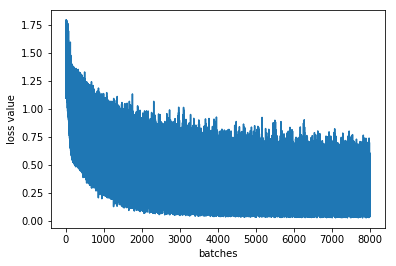

In [18]:
plt.plot(loss_history)
plt.ylabel('loss value')
plt.xlabel('batches')
plt.show()

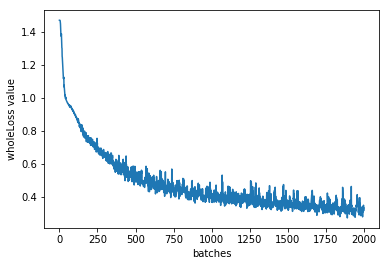

In [19]:
plt.plot(wholeLoss_history)
plt.ylabel('wholeLoss value')
plt.xlabel('batches')
plt.show()

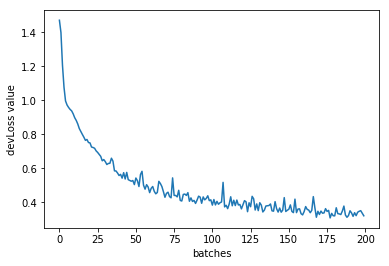

In [20]:
plt.plot(devLoss_history)
plt.ylabel('devLoss value')
plt.xlabel('batches')
plt.show()

### Inference

In [21]:
# Use data point
for seqLen in [minSeqSize,int((minSeqSize+maxSeqSize)/2)]+list(range(maxSeqSize,maxSeqSize+5)):
    X,Y=makeData(seqLen,seqLen,5,1)
    print('Seq:',seqLen)
    print('\tloss:',infer(encoder,decoder,attention,X[seqLen],Y[seqLen],1))
    print('\n\n==============\n\n')

Seq: 3

===== PREDICTED: 0 =====

	- [0.       0.747449]
	- [0.         0.85821843]
	- [1. 0.]

--- ACTUAL: 0 ---

	- [0.       0.747449]
	- [0.         0.85821843]
	- [1. 0.]

===== PREDICTED: 1 =====

	- [0.         0.36103067]
	- [0.         0.50673795]
	- [1. 0.]

--- ACTUAL: 1 ---

	- [0.         0.36103067]
	- [0.         0.50673795]
	- [1. 0.]

===== PREDICTED: 2 =====

	- [0.         0.23713359]
	- [0.         0.45917594]
	- [1. 0.]

--- ACTUAL: 2 ---

	- [0.         0.23713359]
	- [0.         0.45917594]
	- [1. 0.]

===== PREDICTED: 3 =====

	- [0.        0.2292821]
	- [0.        0.5740424]
	- [1. 0.]

--- ACTUAL: 3 ---

	- [0.        0.2292821]
	- [0.        0.5740424]
	- [1. 0.]

===== PREDICTED: 4 =====

	- [0.       0.826495]
	- [0.         0.87104225]
	- [1. 0.]

--- ACTUAL: 4 ---

	- [0.       0.826495]
	- [0.         0.87104225]
	- [1. 0.]
	loss: 0.04802196224530538




Seq: 4

===== PREDICTED: 0 =====

	- [0.         0.48130018]
	- [0.         0.75372434]
	- [0.       